In [10]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D


# Daten einlesen
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# Filtern: Behalten nur positive Bewertungen (rating >= 3.5)
ratings = ratings[ratings["rating"] >= 3.5]

# Filmtitel statt `movieId` verwenden
ratings = ratings.merge(movies, on="movieId", how="left")  # Verknüpfung mit movies.csv
ratings = ratings[["userId", "title"]]  # Nur `userId` und `title` lassen

# Wenig bewertete Filme entfernen (weniger als 10 Bewertungen)
movie_counts = ratings["title"].value_counts()
popular_movies = movie_counts[movie_counts >= 10].index
ratings = ratings[ratings["title"].isin(popular_movies)]

# Transaktionsmatrix
transactions = ratings.groupby("userId")["title"].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
display(df_encoded.head(6))

,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),1408 (2007),2001: A Space Odyssey (1968),2010: The Year We Make Contact (1984),...,Young Guns (1988),Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),¡Three Amigos! (1986)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [37]:
# Apriori-Algorithmus 
# min_support=0.01 → die Filmkombination in mindestens 1% der Nutzer-Transaktionen vorkommen muss.
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True, max_len = 2)

# metric="confidence", min_threshold=0.2 → 
# Die Wahrscheinlichkeit, dass Film Y geschaut wird, wenn Film X gesehen wurde, mindestens 20% beträgt.
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

# Ergebnisse anzeigen
# display(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

print("Identifizierte Regeln ", len(rules))
display(rules[["antecedents", "consequents", "support", "confidence", "lift"]].nlargest(n = 10, columns = "lift"))

Identifizierte Regeln  265341


,antecedents,consequents,support,confidence,lift
220833,"(Mighty Wind, A (2003))",(Spellbound (2002)),0.011494,0.700000,38.754545
220832,(Spellbound (2002)),"(Mighty Wind, A (2003))",0.011494,0.636364,38.754545
144069,(For Your Eyes Only (1981)),"(Spy Who Loved Me, The (1977))",0.014778,0.692308,38.328671
144070,"(Spy Who Loved Me, The (1977))",(For Your Eyes Only (1981)),0.014778,0.818182,38.328671
39727,(Thor: Ragnarok (2017)),(Avengers: Infinity War - Part I (2018)),0.016420,0.625000,38.062500
39728,(Avengers: Infinity War - Part I (2018)),(Thor: Ragnarok (2017)),0.016420,1.000000,38.062500
149718,(The Hateful Eight (2015)),(Fury (2014)),0.011494,0.583333,35.525000
149719,(Fury (2014)),(The Hateful Eight (2015)),0.011494,0.700000,35.525000
257576,(Thunderball (1965)),"(Spy Who Loved Me, The (1977))",0.013136,0.615385,34.069930
257577,"(Spy Who Loved Me, The (1977))",(Thunderball (1965)),0.013136,0.727273,34.069930


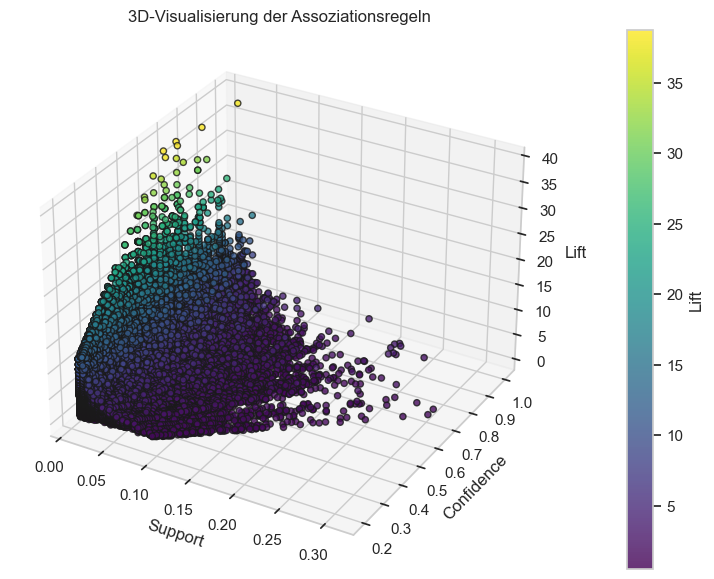

'\nsns.set(style = "whitegrid")\nfig = plt.figure(figsize=(12, 12))\nax = fig.add_subplot(projection = \'3d\')\n\nx = rules[\'support\']\ny = rules[\'confidence\']\nz = rules[\'lift\']\n\nax.set_xlabel("Support")\nax.set_ylabel("Confidence")\nax.set_zlabel("Lift")\n\nax.scatter(x, y, z, c=z)\nax.set_title("3D Distribution of Association Rules")\nplt.show()\n'

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


# 3D-Plot mit Seaborn und Matplotlib
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Punktwolke in 3D zeichnen
sc = ax.scatter(
    rules["support"],
    rules["confidence"],
    rules["lift"],
    c=rules["lift"],  # Farbe basierend auf Lift-Wert
    cmap="viridis",
    alpha=0.8,
    edgecolors="k"
)

# Achsentitel
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_zlabel("Lift")
ax.set_title("3D-Visualisierung der Assoziationsregeln")

# Farbskala hinzufügen
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Lift")

plt.show()
